In [1]:
import cv2
import numpy as np
import os
import pytesseract as pt

In [2]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

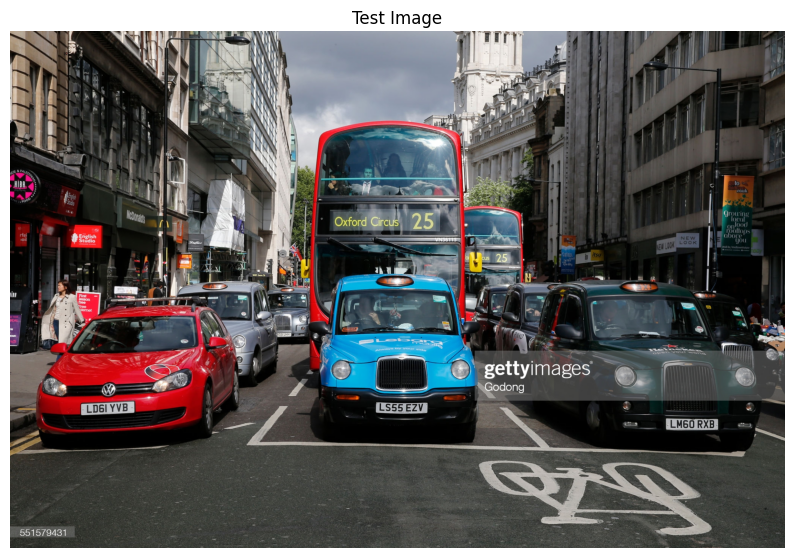

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('test_images/getty_sample.jpg')

# Convert BGR to RGB (OpenCV loads images in BGR format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.title('Test Image')
plt.show()

In [4]:
import cv2

# LOAD YOLO MODEL
try:
    net = cv2.dnn.readNetFromONNX('Model/weights/best.onnx')
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


# # For CUDA GPU acceleration
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# # For OpenCL GPU acceleration
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

Model loaded successfully!


In [5]:
def get_detections(img,net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    # FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten()
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [6]:
# predictions
def yolo_predictions(img,net):
    ## step-1: detections
    input_image, detections = get_detections(img,net)
    ## step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    ## step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [7]:
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return ''
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [8]:
# test
img1 = cv2.imread('test_images/getty_sample.jpg')

results1 = yolo_predictions(img1,net)

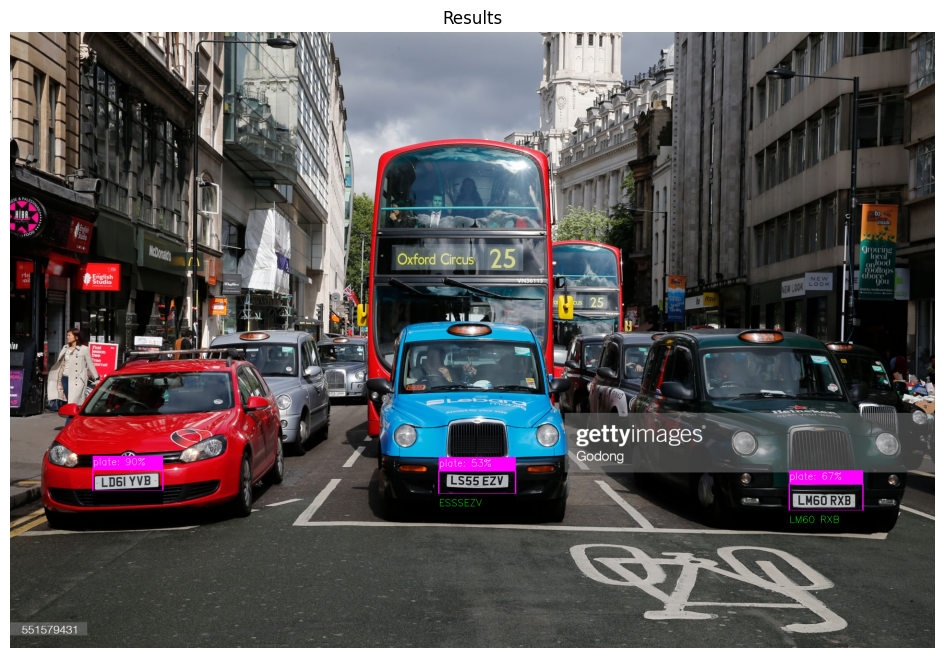

In [9]:
import matplotlib.pyplot as plt

# Convert BGR to RGB (OpenCV uses BGR, matplotlib uses RGB)
results_rgb1 = cv2.cvtColor(results1, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(results_rgb1)
plt.axis('off')
plt.title('Results')
plt.show()

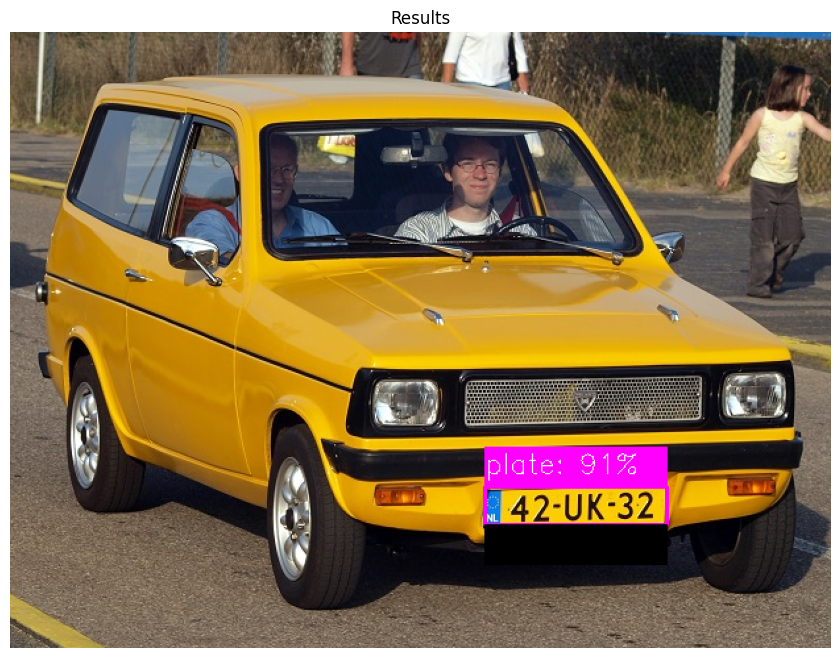

In [10]:
img2 = cv2.imread('test_images/N22.jpg')

results2 = yolo_predictions(img2,net)


results_rgb2 = cv2.cvtColor(results2, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(results_rgb2)
plt.axis('off')
plt.title('Results')
plt.show()

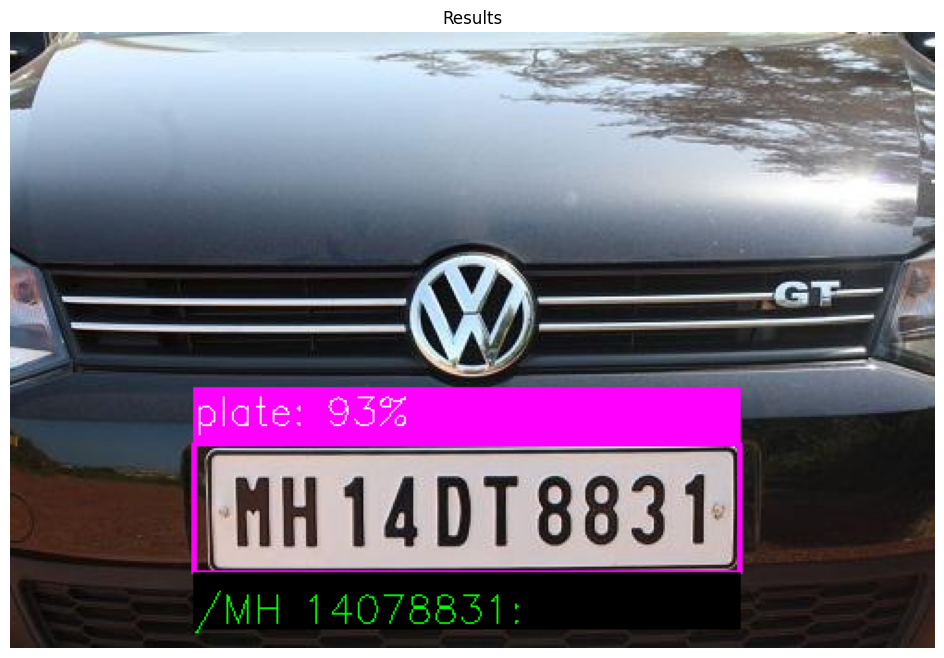

In [11]:
img3 = cv2.imread('test_images/N50.jpeg')

results3 = yolo_predictions(img3,net)


results_rgb3 = cv2.cvtColor(results3, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(results_rgb3)
plt.axis('off')
plt.title('Results')
plt.show()

### Real Time Object Detection

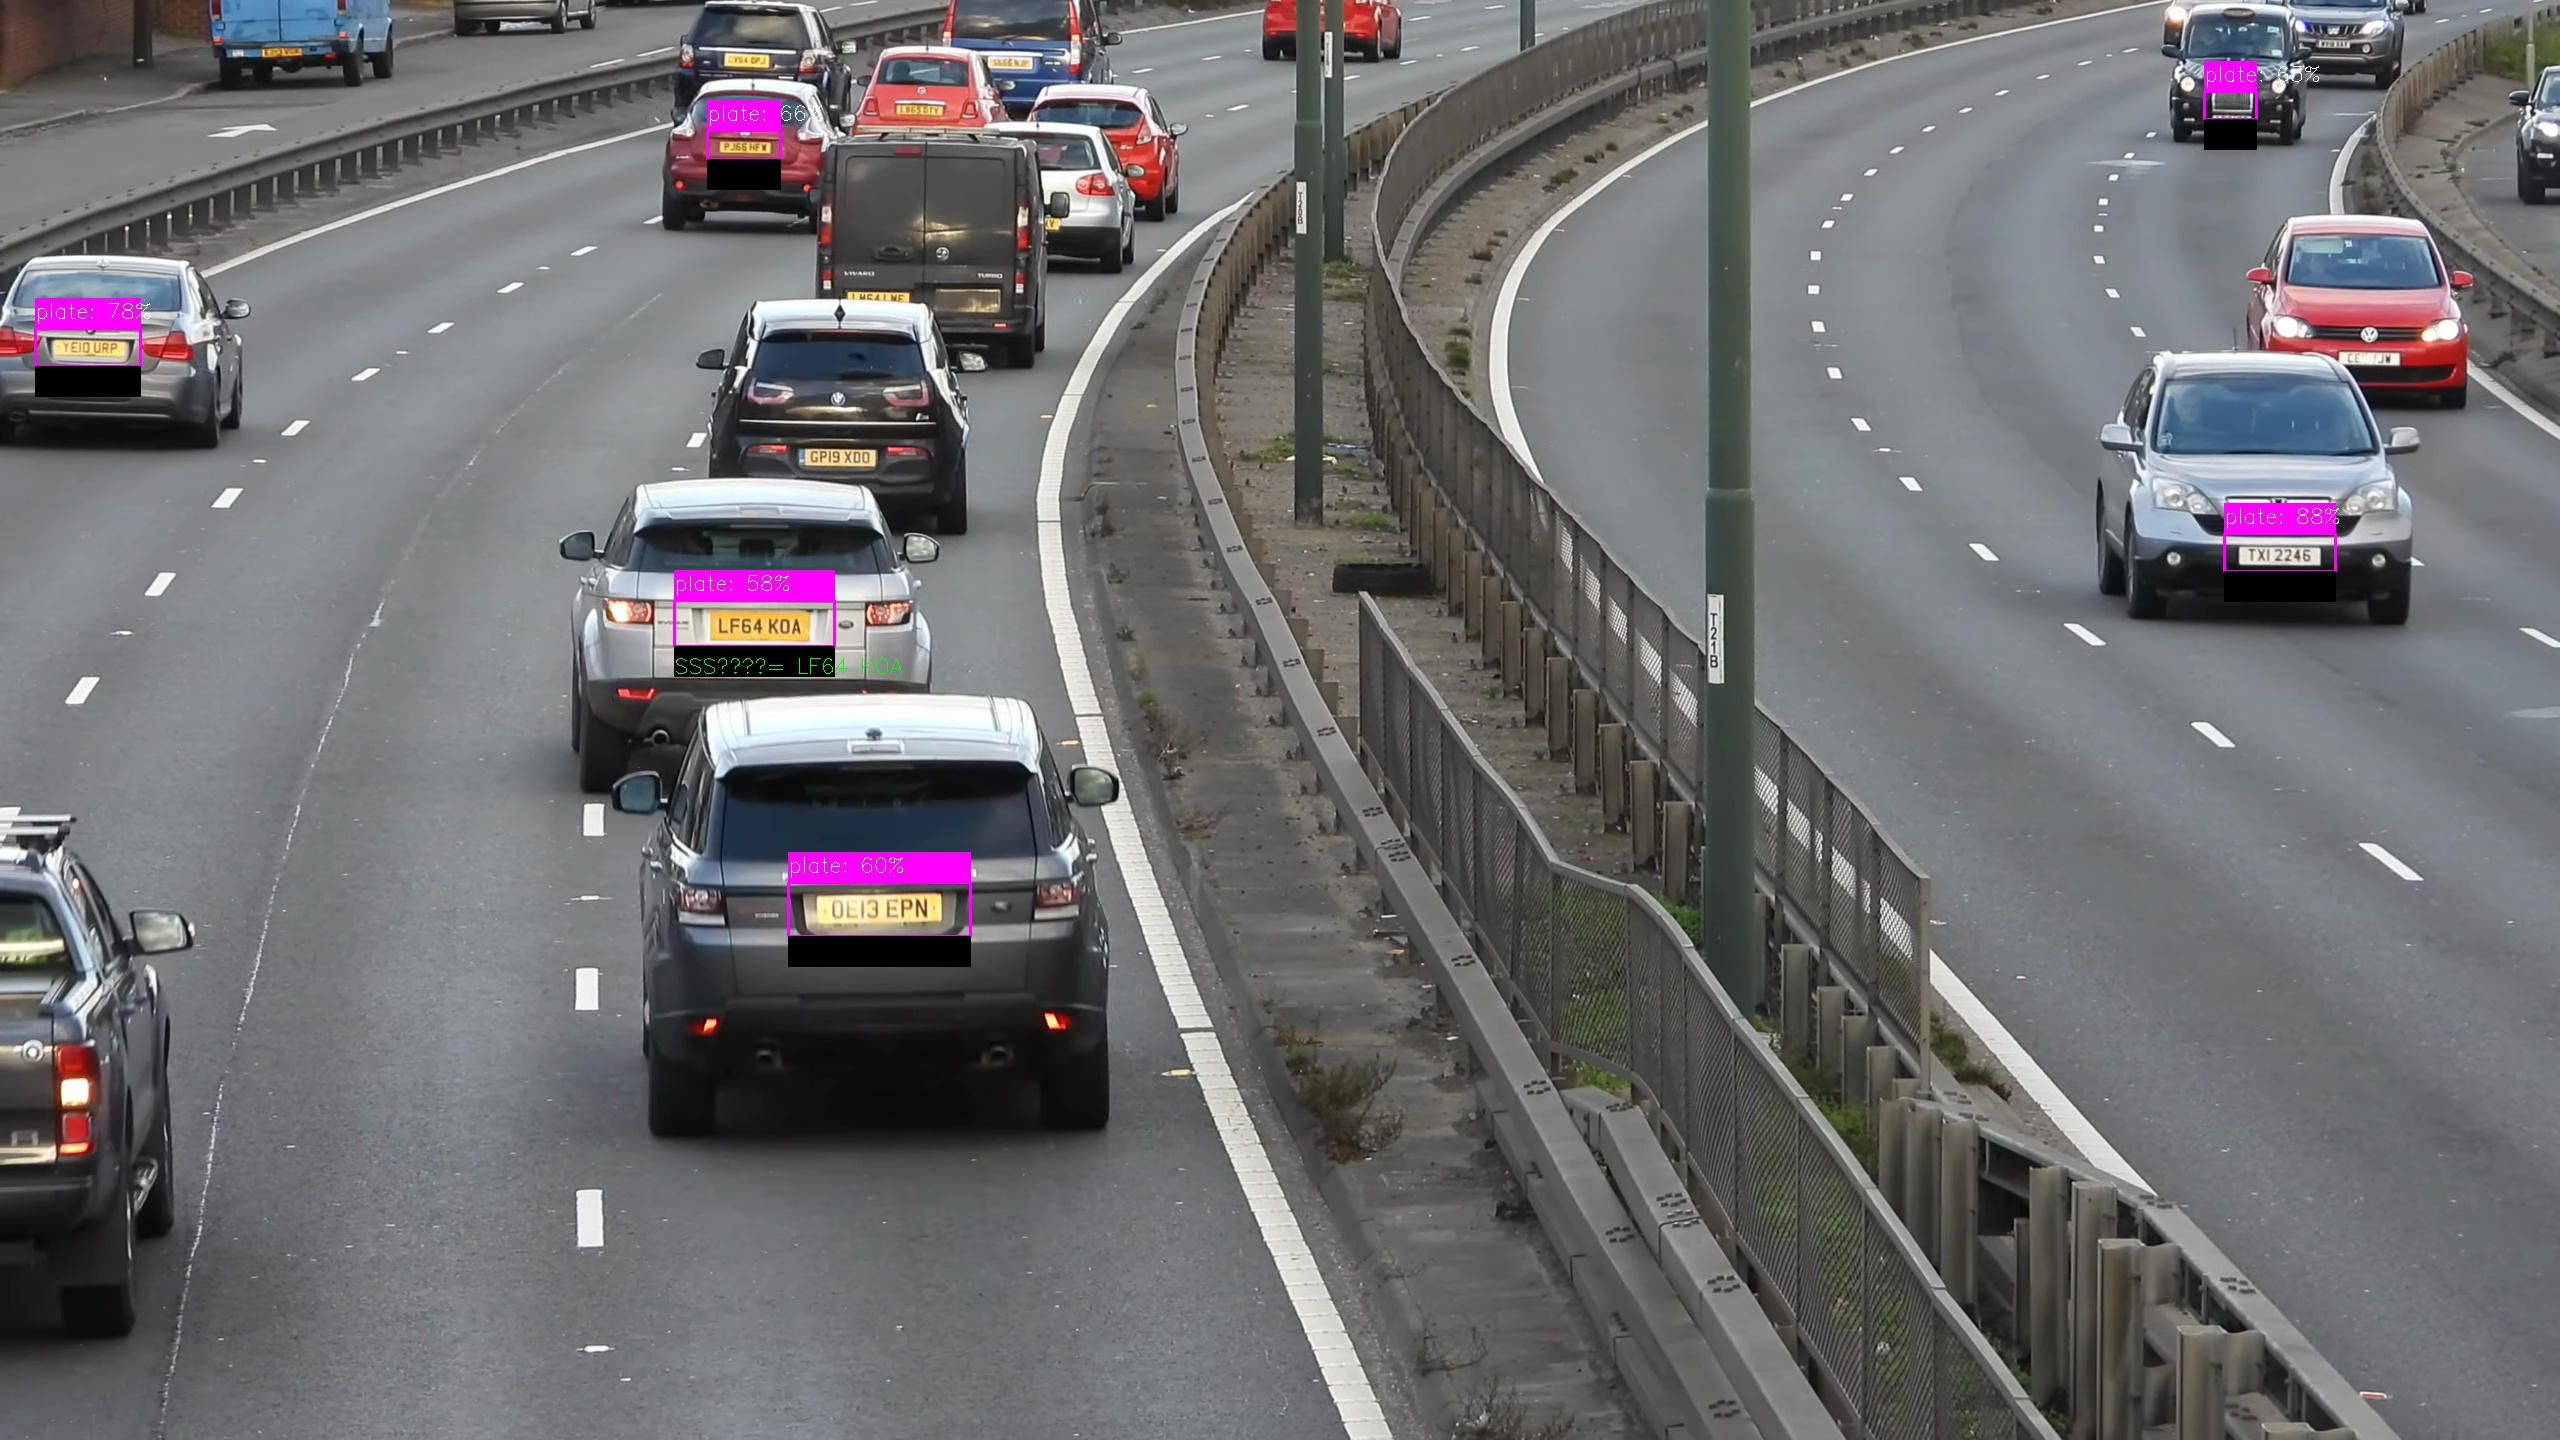

Processing frame 249...
Stopped by user
Done! Saved 249 frames to output_result.mp4


In [24]:
from IPython.display import display, clear_output, Image

cap = cv2.VideoCapture('test_images/traffic.mp4')

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_result.mp4', fourcc, fps, (width, height))

frame_count = 0

try:
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print('Video ended')
            break
        
        results = yolo_predictions(frame, net)
        
        # Save frame to video
        out.write(results)
        
        # Display every 3rd frame (faster performance)
        frame_count += 1
        if frame_count % 3 == 0:
            _, encoded = cv2.imencode('.jpg', results)
            clear_output(wait=True)
            display(Image(data=encoded.tobytes()))
            print(f'Processing frame {frame_count}...')

except KeyboardInterrupt:
    print('Stopped by user')

finally:
    cap.release()
    out.release()
    print(f'Done! Saved {frame_count} frames to output_result.mp4')

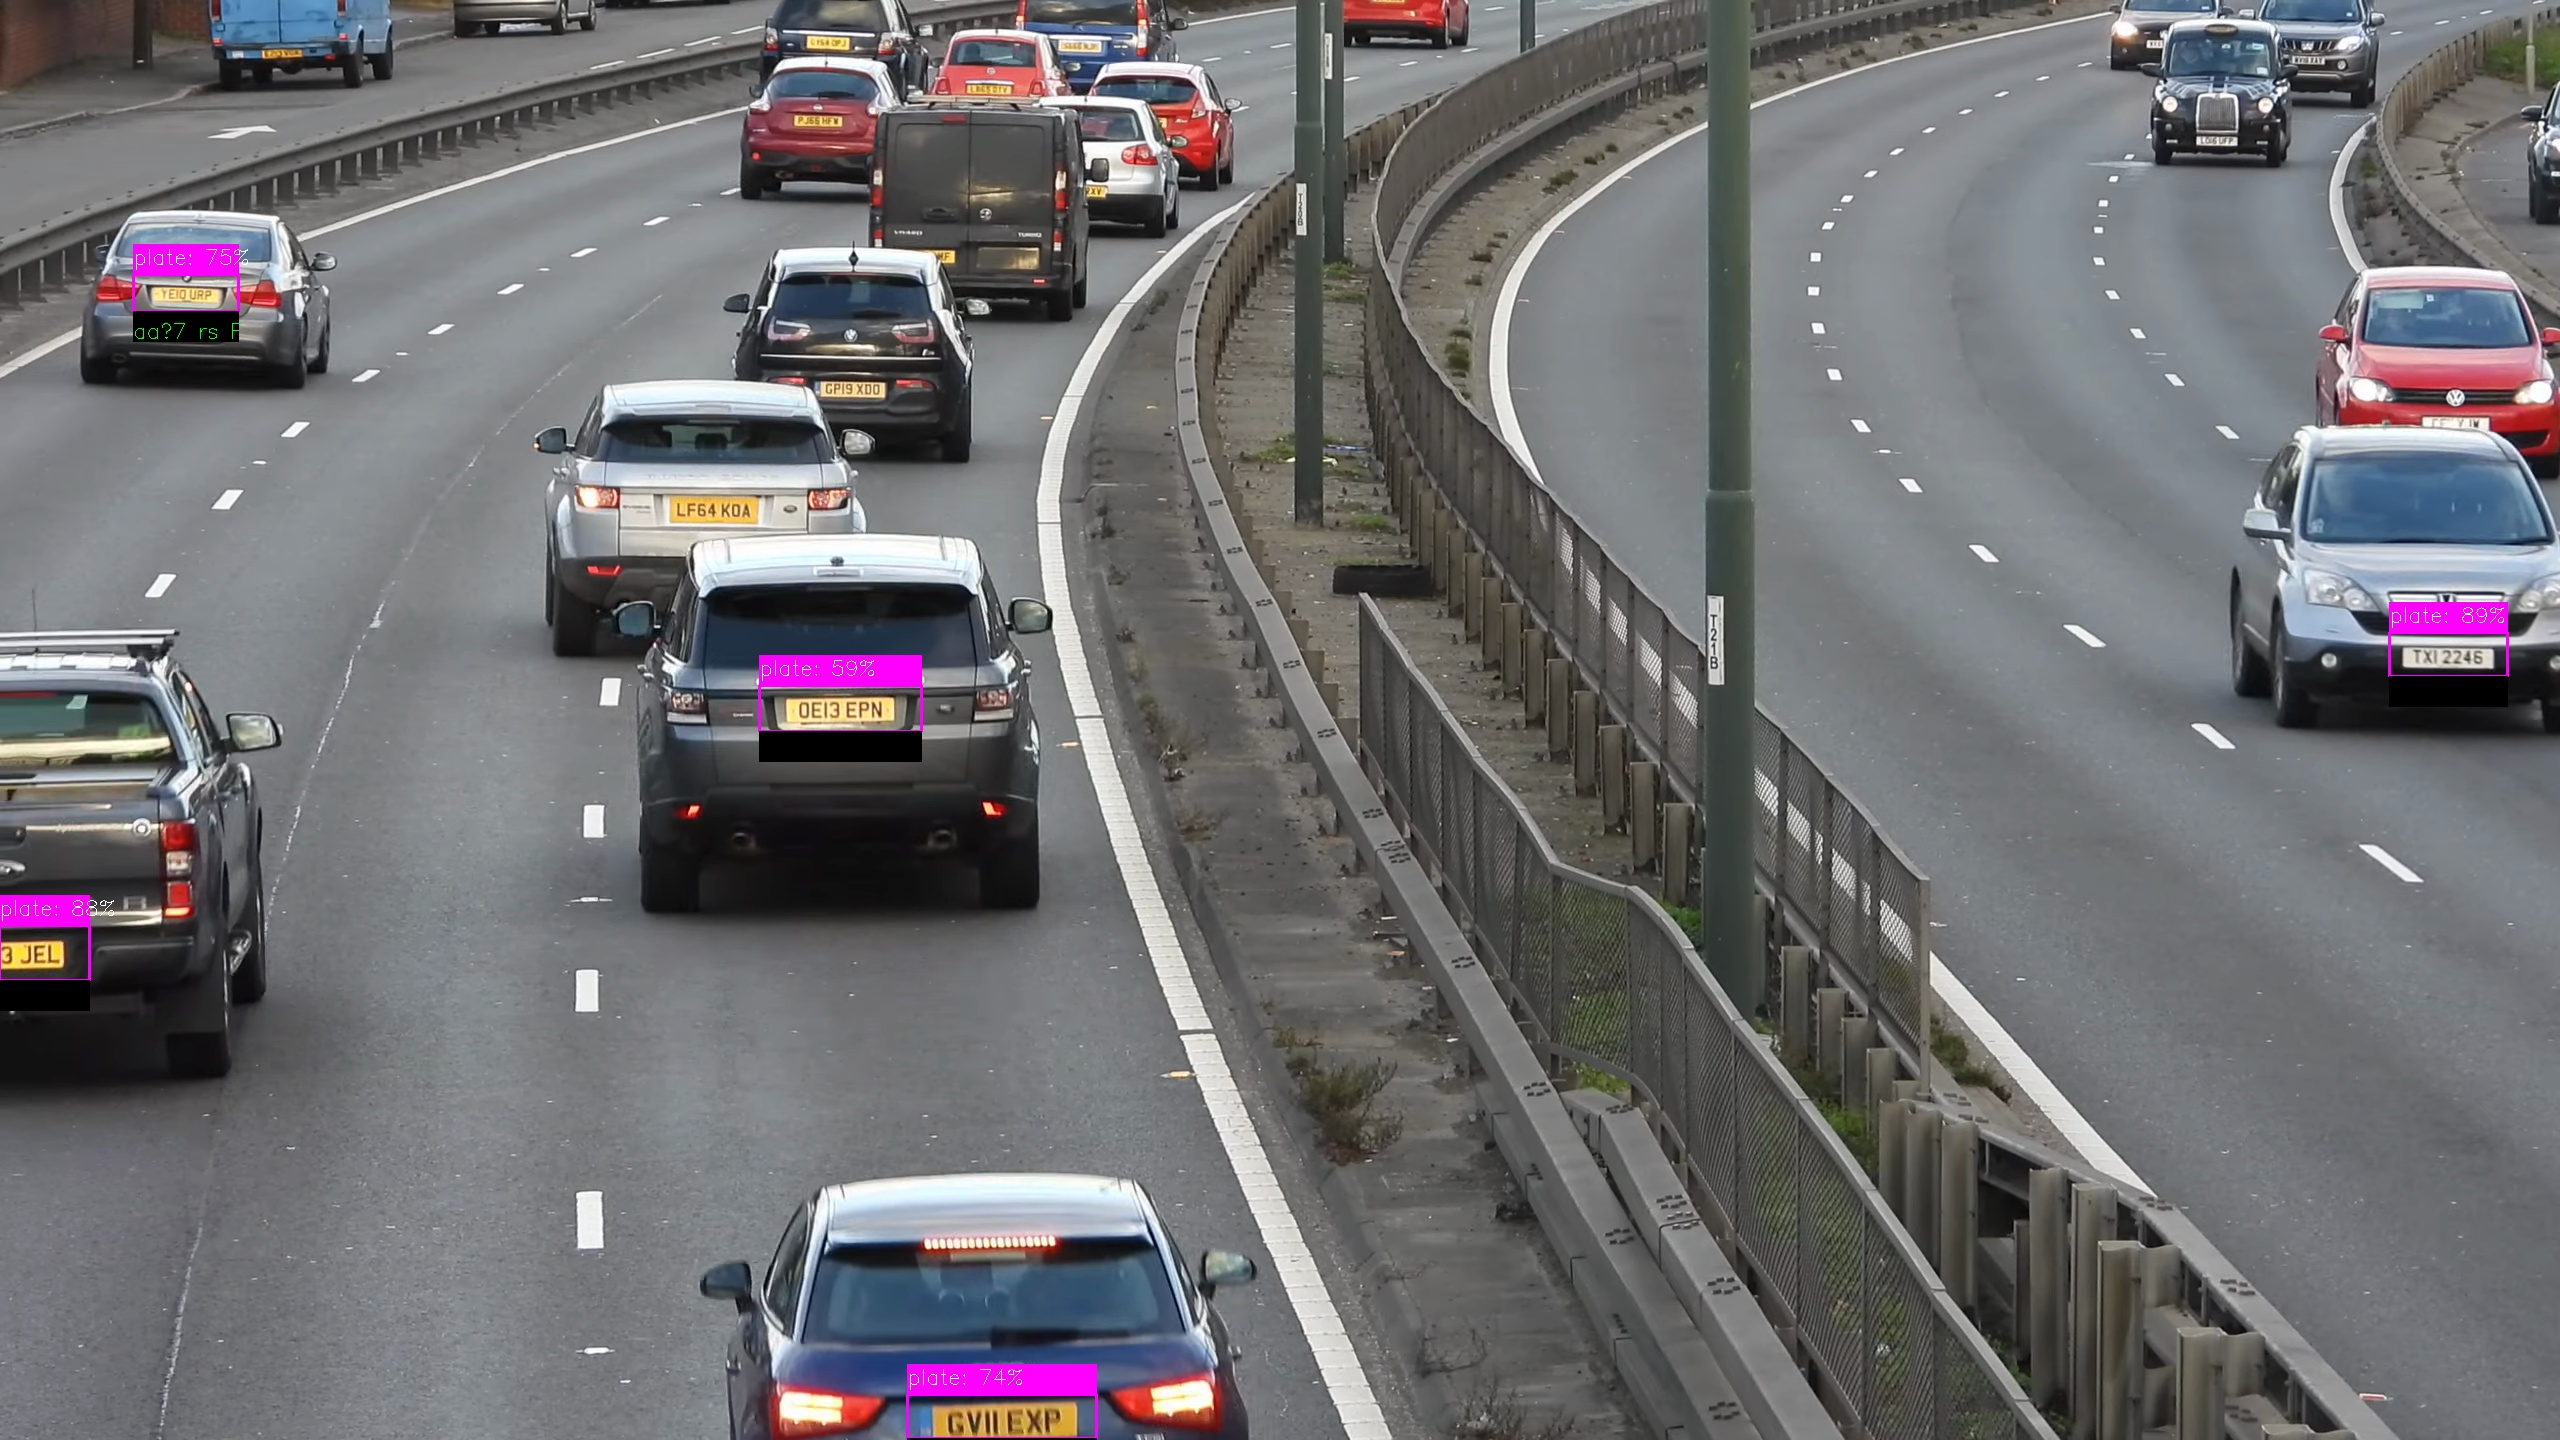

Processing frame 261...
Stopped by user
Done! Saved 261 frames to output_result.mp4


In [25]:
# from IPython.display import display, clear_output, Image

# # Load model with GPU
# net = cv2.dnn.readNetFromONNX('Model/weights/best.onnx')
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# cap = cv2.VideoCapture('test_images/traffic.mp4')

# # Get video properties
# fps = int(cap.get(cv2.CAP_PROP_FPS))
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# # Create video writer
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter('output_result.mp4', fourcc, fps, (width, height))

# frame_count = 0

# try:
#     while True:
#         ret, frame = cap.read()
        
#         if not ret:
#             print('Video ended')
#             break
        
#         results = yolo_predictions(frame, net)
        
#         # Save frame to video
#         out.write(results)
        
#         # Display every 3rd frame
#         frame_count += 1
#         if frame_count % 3 == 0:
#             _, encoded = cv2.imencode('.jpg', results)
#             clear_output(wait=True)
#             display(Image(data=encoded.tobytes()))
#             print(f'Processing frame {frame_count}...')

# except KeyboardInterrupt:
#     print('Stopped by user')

# finally:
#     cap.release()
#     out.release()
#     print(f'Done! Saved {frame_count} frames to output_result.mp4')